## Read chains and extract the best fit parameters. 

In [2]:
## Use the setup.py file to output directories. 
import sys
sys.path.append('/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/')

from setup import *
toolsdir = tools_dir()
repodir = repo_dir()
chainsdir = chains_dir()
datadir = data_dir()
plotdir = plots_dir()

sys.path.append(toolsdir)
sys.path.append(repodir)

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Calling the functions. 

In [4]:
import sys
sys.path.append('/global/u1/z/zzhang13')

from mcmc_full_models import *
from kllr.kllr.regression_model import *
from kllr.kllr.regression_plotting import *
from kllr.kllr.calc_cov_KLLR import *

nBootstrap=100

In [5]:
model_dict ={'erf':{'Ndim':4, 'model_func':model_erf, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'erf_reduced':{'Ndim':3, 'model_func':model_erf_reduced, 'x0':[0.5, -0.5, 1e12], 'x_final:':[],
                         },
    
            'logistics':{'Ndim':4, 'model_func':model_logistics, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'algebraic_2nd':{'Ndim':4, 'model_func':model_algebraic_2nd, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
             
             'arctan':{'Ndim':4, 'model_func':model_arctan, 'x0':[0.5, -0.5, -1, 1e12], 'x_final:':[],
                         },
            }

## Data Vector

In [6]:
from data_bins import r_cent_lin_norm, r_cent_log_norm
from data_bins import mass_bins, mass_bin_cent
from data_bins import a_bins

In [7]:
with open(datadir + 'MDPL2_DS_R200c_SAGE_Ngal_allM_allz.p', 'rb') as handle:
    matched_halo_df = pickle.load(handle)
matched_halo_df.columns

Index(['id', 'Xoff', 'scale', 'CtreesHaloID', 'pid', 'mvir', 'rvir', 'rs', 'x',
       'y', 'z', 'Mmvir_all', 'M200b', 'M200c', 'M500c', 'T/|U|',
       'Halfmass_Scale', 'Acc_Rate_Inst', 'Acc_Rate_100Myr', 'Acc_Rate_1*Tdyn',
       'Acc_Rate_2*Tdyn', 'Acc_Rate_Mpeak', 'c_vir', 'R200c', 'R500c',
       'redshift', 'Ngal_Dsep_1', 'Ngal_Rvir', 'Ngal_R200c', 'Ngal_R500c',
       'sigma', 'r_range', 'delta_sigma'],
      dtype='object')

In [8]:
cov_bin_dict = {'R200c_binned_Dsep_1Mpc':{'filedir': 'R200c_binned/Dsep_1/',  'Mbin':'M200c', 'Ngal_def':'Ngal_Dsep_1'}, \
                                             
                   'R200c_binned_Dsep_R200c':{'filedir': 'R200c_binned/Dsep_R200c/', 'Mbin':'M200c', 'Ngal_def':'Ngal_R200c'}, \
                                             
                   'Rvir_binned_Dsep_1':{'filedir': 'Rvir_binned/Dsep_1/', 'Mbin':'M200c', 'Ngal_def':'Ngal_Dsep_1'}, \
                                             
                   'Rvir_binned_Dsep_Rvir':{'filedir': 'Rvir_binned/Dsep_Rvir/', 'Mbin':'mvir', 'Ngal_def':'Ngal_Rvir'} \
                  }




## Compare the DIC of different functions

### Comparing the full models

In [8]:
## Looping through M,z,function bins and reading the correct file
for i, cur_a_bin in enumerate(a_bins):
    for j, cur_mass_bin in enumerate(mass_bins):
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
    
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        
        redshift = 1/cur_a_bin - 1
        redshift_str = '{:.2f}'.format(redshift)
        redshift_str = redshift_str.replace('.','p')
        
        #Collect the data vector
        if len(cur_df) < 100: 
            #axs[i,j].set_visible(False)
            continue
            
        ##Computing the Covariance##
        ##Compute Cov. and error total
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        
        ##Nominal model
        model = model_dict['erf_reduced']['model_func']
        Ndim = model_dict['erf_reduced']['Ndim']
        filename = chainsdir +'R200c_binned/Dsep_R200c/'+'chains_M{:.2g}_{:.2g}_z{}_{}.h5py'.format(mass_min, mass_max, redshift_str, 'erf_reduced')
        f = h5py.File(filename,'r')
        print(filename, '\n')
        chain = np.array(f['chains'])
        #flatchain = chain.reshape((-1,Ndim)).T
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model_erf_reduced, Ndim, x_data, y_data, y_err, verbose=True)
        
        continue
        for model_name, model_info in model_dict.items():
            model = model_info['model_func']
            Ndim = model_info['Ndim']
            filename = chainsdir +'R200c_binned/Dsep_R200c/' + 'chains_M{:.2g}_{:.2g}_z{}_{}.h5py'.format(mass_min, mass_max, redshift_str, model_name)
            f = h5py.File(filename,'r')
            chain = np.array(f['chains'])
            #flatchain = chain.reshape((-1,Ndim)).T
            #print(filename, )
            
            best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=False)
            #print('DIC_model - DIC_nominal', DIC_model-DIC_nominal, '\n')


/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/R200c_binned/Dsep_R200c/chains_M5e+13_1e+14_z0p00_erf_reduced.h5py 

R = [1.00037521 1.00037443 1.00035248]
param_0: best fit, upper_err, lower_err:  [0.44128823 0.04708169 0.04117395]
param_1: best fit, upper_err, lower_err:  [-0.62693293  0.06984703  0.08783488]
param_2: best fit, upper_err, lower_err:  [2.65519531e+12 5.58650418e+11 3.91003095e+11]
DIC:  [1079.50238726]
BIC:  [1082.00929514]
Chi-square p-value:  0.03770286072003626
/global/homes/z/zzhang13/BaryonPasting/CorrelatedStructures/multiDark/data/chains/R200c_binned/Dsep_R200c/chains_M1e+14_2e+14_z0p00_erf_reduced.h5py 

R = [1.00168442 1.00182512 1.0022411 ]
param_0: best fit, upper_err, lower_err:  [0.68586468 0.10503481 0.0911042 ]
param_1: best fit, upper_err, lower_err:  [-0.98125971  0.19787679  0.2674715 ]
param_2: best fit, upper_err, lower_err:  [4.10084948e+12 2.31041239e+12 1.18634588e+12]
DIC:  [1056.81543355]
BIC:  [1062.27905763]

## Plotting 

### Model vs Data
* Comparing Ngal_R200c binned by R200c model vs data. 

Todo: Remove the model for the two bins that have unconstrained values. 

In [10]:
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

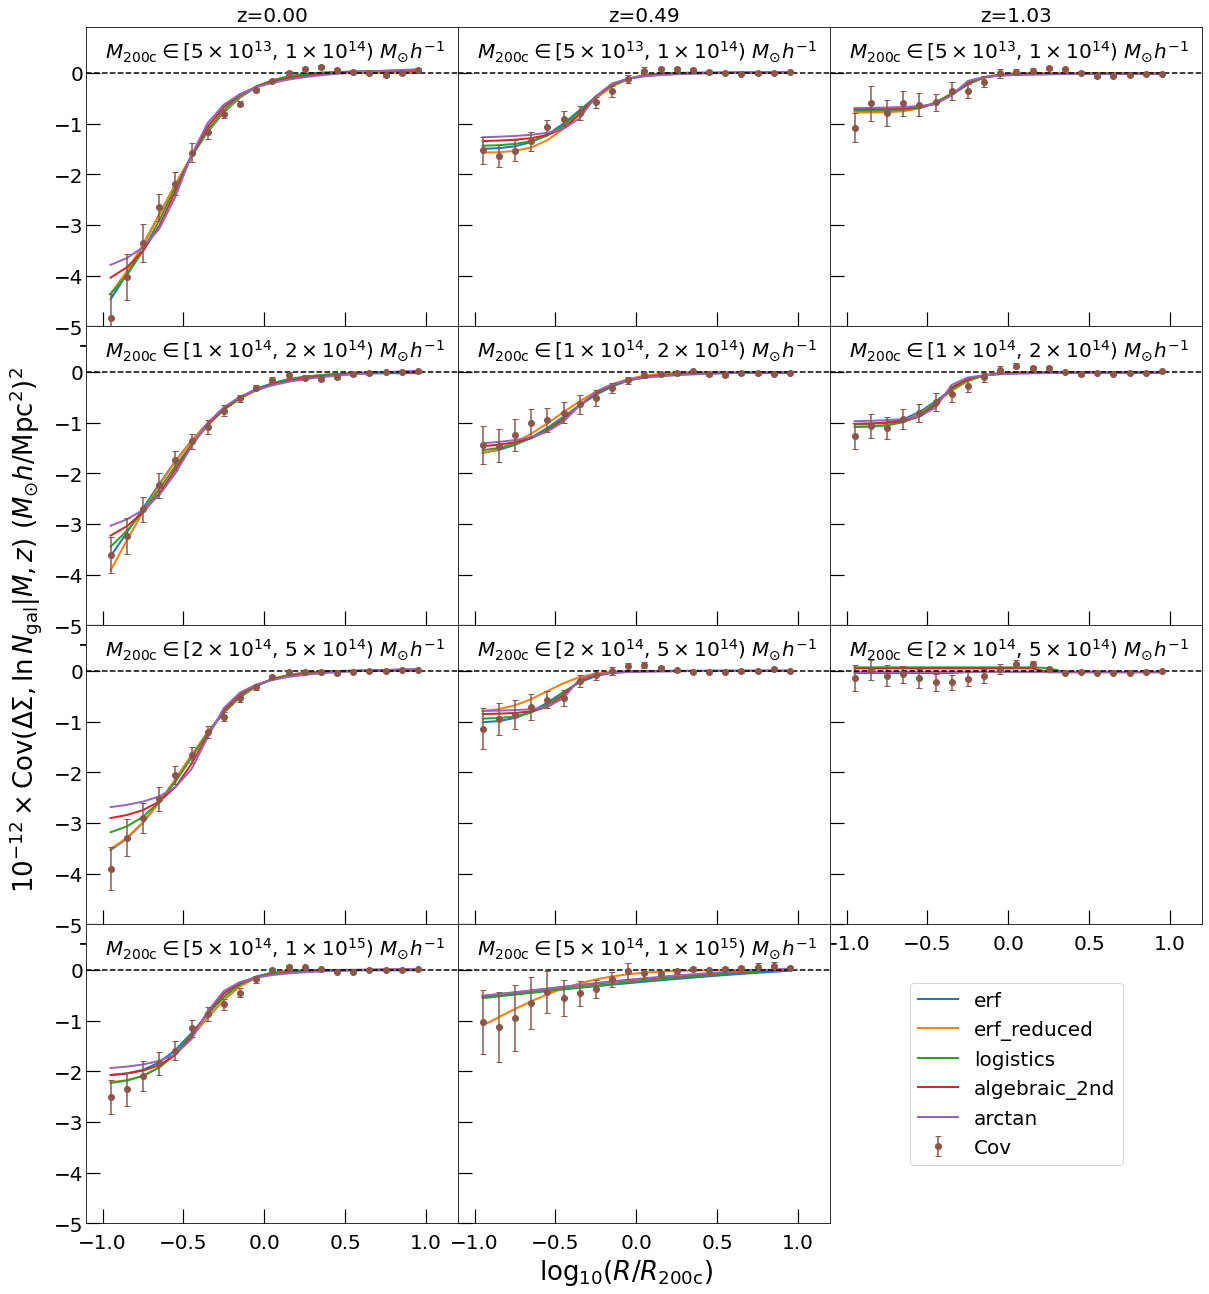

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(20,22), sharex=False, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
fontsize=26
nBootstrap=20
legendsize = 20

for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):
        
        
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
    
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        
        redshift = 1/cur_a_bin - 1
        redshift_str = '{:.2f}'.format(redshift)
        redshift_str = redshift_str.replace('.','p')
        
        #Collect the data vector
        if len(cur_df) < 100: 
            axs[i,j].set_visible(False)
            continue
            
        ##Computing the Covariance##  
        
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = np.std(cov_ds_ngal_kllr, axis=0)
        
        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr/1e12; y_err = cov_err_kllr/1e12
        
        k=0
        for key, value in model_dict.items():
            #if key != 'Nonsense': continue
            Ndim = value['Ndim']
            model = value['model_func']
            x0 = value['x0']
            model_name = key
            
            filename = chainsdir + 'R200c_binned/Dsep_R200c/'+ 'chains_M{:.2g}_{:.2g}_z{}_{}.h5py'.format(mass_min, mass_max, redshift_str, model_name)
            f = h5py.File(filename,'r')
            chain = np.array(f['chains'])
            #flatchain = chain.reshape((-1,Ndim)).T
            
            best_fit_params, DIC_model, BIC_model, p_val = posterior_summary_stats(chain, model, Ndim, x_data, y_data, y_err, verbose=False)
            
            
            model_dict[key]['x_final'] = best_fit_params
            fit = model(best_fit_params[:,0], x_data)
            
            axs[i,j].plot(x_data, fit/1e12, label=key, color='C{}'.format(k), linewidth=2)
            k+=1
        
        axs[i,j].errorbar(x_data, y_data, yerr=y_err, label='Cov', marker="o", capsize=3, linestyle='None', color='C5')  
    
        ##Plotting configure
        axs[i,j].axhline(0,linestyle='dashed', color='black')
        axs[i,j].set_ylim([-5,0.9])
        axs[i,j].set_xlim([-1.1,1.2])
        
        if i == 0: axs[i,j].set_title('z={:.2f}'.format(1/cur_a_bin-1), fontsize=20)
        axs[i,j].text(0.05, 0.9,  r'$M_{\rm 200c} \in $'+r'[${0:s}$, '.format(as_si(mass_min,0)) + r'${0:s}$)'.format(as_si(mass_max,0)) + ' $M_{\odot}h^{-1}$', \
                      fontsize = 20, transform=axs[i,j].transAxes)

fig.text(0.5, 0.09, r'$\log_{10}(R/R_{\rm 200c})$', fontsize=fontsize, ha='center')
fig.text(0.07, 0.5, r'$10^{-12} \times \mathrm{Cov}$' +r'$(\Delta\Sigma, \lnN_{\rm gal} | M, z)$ ($M_{\odot}h$/Mpc$^2$)$^2$', fontsize=fontsize, va='center', rotation='vertical')

#axs[0,0].legend(loc='lower right', fontsize=14)

axs[3,0].legend(loc='center', bbox_to_anchor=(2.5,0.5), fontsize=legendsize)
plt.margins(tight=True)
plt.savefig(plotdir+'cov_M200c_Dsep_R200c_all_models.pdf', bbox_inches='tight')
plt.show()

## Null test

In [ ]:
## Chi_squared estimator
def chisqr_null(obs, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + (obs[i]**2)/(error[i]**2)
    return chisqr

In [ ]:
nBootstrap = 10
for i, cur_mass_bin in enumerate(mass_bins):
    for j, cur_a_bin in enumerate(a_bins):
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
    
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        
        #Collect the data vector
        if len(cur_df) < 100: 
            continue
            
        ##Computing the Covariance##  
        
        xline, output = calc_cov_KLLR(np.log10(np.array(cur_df['M200c'],dtype=float)) , np.array(np.vstack(cur_df['delta_sigma']), dtype=float), \
                                       np.log10(np.array(cur_df['Ngal_R200c'],dtype=float)), nBootstrap=nBootstrap)
        cov_ds_ngal_kllr = output['covariance']
        cov_mean_kllr = np.mean(cov_ds_ngal_kllr, axis=0)
        cov_err_kllr = 1.2*np.std(cov_ds_ngal_kllr, axis=0)
        
        ##Data vector for chains
        x_data = r_cent_log_norm; y_data = cov_mean_kllr; y_err = cov_err_kllr
        
        chisqr = chisqr_null(y_data, y_err)
        
        ##Chi-square p-value
        p_val = 1 - stats.chi2.cdf(chisqr, len(y_data))
        print('M{:.2g}_{:.2g}_z{}'.format(mass_min, mass_max, 1/cur_a_bin-1))
        print("Chisqr:{}, p_val:{}".format(chisqr, p_val))

In [ ]:
p_val = 1 - stats.chi2.cdf(40, len(y_data)-1)
print(p_val)

## Compare the parameters 
* First by Mass evolution, then by redshift evolution

### By mass and redshift evoluion for one radial definition

In [ ]:
params_list = [r'$\tau$', r'$\gamma$', r'$g$', r'$10^{-12}\times s$']

In [ ]:
skip_bins = np.array([[1,2,2],[3,2,3]]) # Skip bins where chains do not converge

In [ ]:
fontsize=20
legendsize=14
fig, axs = plt.subplots(4, 1, figsize=(8,12), tight_layout=True, sharex=True)

shift = 1
markers = ['D', 'p', '+']
for i, cur_a_bin in enumerate(a_bins):
    redshift = 1/cur_a_bin - 1
    redshift_str = '{:.2f}'.format(redshift)
    redshift_str = redshift_str.replace('.','p')
    
    mass_bin_cent = []
    for j, cur_mass_bin in enumerate(mass_bins):
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        #mass_bin_cent = mass_bin_cent.append([(mass_min+mass_max)/2])
        mask = (matched_halo_df.M200c >= mass_min) & (matched_halo_df.M200c < mass_max) & (matched_halo_df.scale == cur_a_bin) 
        cur_df = matched_halo_df[mask]
        if len(cur_df) < 100: 
            continue
            
        skip_bin = False
        for k in range(len(skip_bins[1])):
            if (i == skip_bins[0,k]) & (j == skip_bins[1,k]): skip_bin = True
        if skip_bin: continue
        
        model = model_dict['erf']['model_func']
        Ndim = model_dict['erf']['Ndim']
        filename = chainsdir + 'R200c_binned/Dsep_R200c/' + 'chains_M{:.2g}_{:.2g}_z{}_{}.h5py'.format(mass_min, mass_max, redshift_str, 'erf')
        
        try:
            f = h5py.File(filename,'r')
        except:
            continue
            
        mass_bin_cent.append((mass_min+mass_max)/2)
        
        
        chain = np.array(f['chains'])
        #flatchain = chain.reshape((-1,Ndim)).T
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model_erf, Ndim, x_data, y_data, y_err, verbose=False)
        best_fit_params[3,:] /= 1e12

        if j == 0: pmax_param_bin = [best_fit_params]
        else: pmax_param_bin = np.vstack((pmax_param_bin,[best_fit_params]))

    mass_bin_cent = np.array(mass_bin_cent)
    for n, param in enumerate(params_list):
        yerr = [pmax_param_bin[:,n,2], pmax_param_bin[:,n,1]] ##Specify the lower and upper bounds
        y = pmax_param_bin[:,n,0]
        axs[n].errorbar(shift*mass_bin_cent, y, yerr=yerr, fmt=markers[i], capsize=3, label='z={:.2f}'.format(redshift))
        axs[n].set_ylabel(param, fontsize=fontsize)
        axs[n].set_xscale('log')
    
    shift *= 1.05
        

axs[3].set_yscale('log')
axs[0].legend(fontsize=legendsize)
axs[2].axhline(-1, linestyle='dashed', color='black')
axs[3].set_xlabel(r'$M_{\rm 200c} (M_{\odot}h^{-1})$', fontsize=fontsize)
axs[3].set_xlim([5e13,1e15])
axs[3].set_yticks([0.1,0.5,1,2,3], labels=[0.1,0.5,1,2,3])
plt.savefig(plotdir+'cov_params_vary_mass_redshift.pdf')
plt.show()
    
    

## Testing the code on a benchmark run. 

## Change of radius definitions
* R200c_binned_Dsep_1
* R200c_binned_Dsep_R200c
* Rvir_binned_Dsep_1
* Rvir_binned_Dsep_Rvir

In [ ]:
radius_bins_dir = {r'$r_p = R/R_{200c}, R_{halo} = 1$ Mpc/h':'R200c_binned/Dsep_1/', \
                   r'$r_p = R/R_{200c}, R_{halo} = R_{200c}$':'R200c_binned/Dsep_R200c/', \
                   r'$r_p = R/R_{vir}, R_{halo} = 1$ Mpc/h':'Rvir_binned/Dsep_1/', \
                   r'$r_p = R/R_{\rm vir}, R_{halo} = R_{vir}$':'Rvir_binned/Dsep_Rvir/'}


chains_keys = [r'$r_p = R/R_{200c}, R_{halo} = 1$ Mpc/h', r'$r_p = R/R_{200c}, R_{halo} = R_{200c}$', \
               r'$r_p = R/R_{vir}, R_{halo} = 1$ Mpc/h',  r'$r_p = R/R_{\rm vir}, R_{halo} = R_{vir}$', \
               r'$r_p = R/R_{200c}, R_{halo} = R_{200c}, g = -1 $']


In [ ]:
## Plot the contoours in z=0.49 for the different radius bins. 
## Check for convergence of the chains. 
## Compare with the error function only as that is the fiducial model
fontsize=20
legendsize=14
fig, axs = plt.subplots(4, 1, figsize=(8,12), tight_layout=True, sharex=True)

shift = 1 ## Shift the radius bin x-markers by an amount for better visualization
markers = ['D', 'p', '+', '.']
for cur_radius_label, cur_radius_dir in radius_bins_dir.items():
    print(cur_radius_label)
    redshift = 0.00
    redshift_str = '{:.2f}'.format(redshift)
    redshift_str = redshift_str.replace('.','p')
    
    mass_bin_cent = []
    for j, cur_mass_bin in enumerate(mass_bins):
        mass_min = cur_mass_bin[0]; mass_max = cur_mass_bin[1]
        
        model = model_dict['erf']['model_func']
        Ndim = model_dict['erf']['Ndim']
        filename = chainsdir + cur_radius_dir+ 'chains_M{:.2g}_{:.2g}_z{}_{}.h5py'.format(mass_min, mass_max, redshift_str, 'erf')
        
        try:
            f = h5py.File(filename,'r')
        except:
            print("No file")
            continue
            
        mass_bin_cent.append((mass_min+mass_max)/2)
        
        chain = np.array(f['chains'])
        best_fit_params, DIC_nominal, BIC_nominal, p_val = posterior_summary_stats(chain, model_erf, Ndim, x_data, y_data, y_err, verbose=False)
        best_fit_params[3,:] /= 1e12

        if j == 0: pmax_param_bin = [best_fit_params]
        else: pmax_param_bin = np.vstack((pmax_param_bin,[best_fit_params]))

    mass_bin_cent = np.array(mass_bin_cent)
    for n, param in enumerate(params_list):
        yerr = [pmax_param_bin[:,n,2], pmax_param_bin[:,n,1]] ##Specify the lower and upper bounds
        y = pmax_param_bin[:,n,0]
        axs[n].errorbar(shift*mass_bin_cent, y, yerr=yerr, fmt='D', capsize=3, label='{}'.format(cur_radius_label))
        axs[n].set_ylabel(param, fontsize=fontsize)
        axs[n].set_xscale('log')
        
    shift *= 1.05

axs[3].set_yscale('log')
axs[0].legend(fontsize=legendsize, framealpha=0.5)
axs[2].axhline(-1, linestyle='dashed', color='black')
axs[3].set_xlabel(r'$M_{\rm 200c} (M_{\odot}h^{-1})$', fontsize=fontsize)
axs[3].set_xlim([5e13,1e15])
axs[3].set_yticks([1,2,3,4], labels=[1,2,3,4])
plt.suptitle(r'z=0.00', fontsize=fontsize)
plt.savefig(plotdir+'cov_params_vary_Ngal.pdf')
plt.show()
    

## Plotting the Covariance & Radius definitions


## Contour plots

In [ ]:
import corner
tmp = corner.corner(chain.T, labels=['gamma', 'tau', 'h', r'$10^{12}\times s$'],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12},
                    title_fmt='.2g',
                    #axes_scale=['linear','linear','linear','log'],
                    max_n_ticks=3,
                    use_math_text=True,
                    #range=[(0,0.4),(-2,0),(0.9,1),(1e12,1e13)]
                   )
for i, ax in enumerate(tmp.get_axes()):
    #if i==12: ax.set_xscale('log')
    #if i>=13: ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
#tmp.savefig(plot_dir + 'mcmc_logistic_cornerplot.pdf')